In [1]:
import json
from matplotlib import pyplot as plt
import microhapdb
import pandas as pd
from pathlib import Path

In [2]:
microhapdb.__version__

'0.11+1.gcef486c.dirty'

In [3]:
def aggregate_counts_and_averages():
    counts = pd.concat(map(sample_read_counts, ("SRM8398-1", "SRM8398-2", "SRM8398-3", "SRM8398-4")))
    counts["RepeatRate"] = counts.apply(lambda row: row.RepetitiveReads / row.TotalReads if row.TotalReads > 0 else 0.0, axis=1)
    counts["Locus"] = counts.Marker.apply(lambda x: x.split(".")[0])
    counts = counts.sort_values(["Marker", "Sample"]).reset_index(drop=True)
    averages = list()
    for markerid, subset in counts.groupby("Marker"):
        avg_repeat_rate = sum(subset.RepeatRate) / len(subset.RepeatRate)
        averages.append((markerid, avg_repeat_rate, subset.Length.iloc[0], subset.Ae.iloc[0]))
    averages = pd.DataFrame(averages, columns=["Marker", "RepeatRate", "Length", "Ae"])
    averages["Locus"] = averages.Marker.apply(lambda x: x.split(".")[0])
    averages = averages.sort_values("RepeatRate", ascending=False).reset_index(drop=True)
    return counts, averages

In [4]:
def sample_read_counts(sample_name):
    type_path = f"../scratch/WD_hybcap3_2023-11-07/analysis/{sample_name}/{sample_name}-type.json"
    repeat_path = f"../scratch/WD_hybcap3_2023-11-07/analysis/{sample_name}/{sample_name}-repetitive-reads.csv"
    table = parse_typed_read_counts(type_path)
    table = flag_repetitive_markers(table, repeat_path)
    table = incorporate_length_and_ae(table)
    table["Sample"] = sample_name
    return table[["Sample", "TotalReads", "TypedReads", "RepetitiveReads", "RepFlagged", "Length", "Ae"]].reset_index()

In [5]:
def parse_typed_read_counts(typing_counts_path):
    data = list()
    with open(typing_counts_path, "r") as fh:
        result = json.load(fh)
    for marker in result["markers"]:
        typed_reads = sum(result["markers"][marker]["typing_result"].values())
        untyped_reads = result["markers"][marker]["num_discarded_reads"]
        total_reads = typed_reads + untyped_reads
        data.append((marker, total_reads, typed_reads))
    return pd.DataFrame(data, columns=["Marker", "TotalReads", "TypedReads"]).set_index("Marker")

In [6]:
def flag_repetitive_markers(table, repeat_counts_path):
    data = pd.read_csv(repeat_counts_path)
    data["RepFlagged"] = data.Marker.apply(lambda x: x in microhapdb.repeats.index)
    data = data.set_index("Marker")
    return table.join(data, on="Marker")

In [7]:
def incorporate_length_and_ae(table):
    data = microhapdb.markers[["Name", "Extent", "Ae"]].copy().rename(columns={"Name": "Marker", "Extent": "Length"}).set_index("Marker")
    return table.join(data, on="Marker")

In [8]:
counts, averages = aggregate_counts_and_averages()

In [9]:
counts[counts.RepeatRate > 0.15]

,Marker,Sample,TotalReads,TypedReads,RepetitiveReads,RepFlagged,Length,Ae,RepeatRate,Locus
0,mh01CP-007,SRM8398-1,7058,6827,4562,True,17,1.330,0.646359,mh01CP-007
1,mh01CP-007,SRM8398-2,8148,7880,5559,True,17,1.330,0.682253,mh01CP-007
2,mh01CP-007,SRM8398-3,6066,5861,4038,True,17,1.330,0.665678,mh01CP-007
3,mh01CP-007,SRM8398-4,8491,8186,5881,True,17,1.330,0.692616,mh01CP-007
4,mh01CP-008,SRM8398-1,4120,3150,4120,True,17,2.697,1.000000,mh01CP-008
...,...,...,...,...,...,...,...,...,...,...
2427,mh20LV-04.v1,SRM8398-4,20662,12,19097,True,350,40.974,0.924257,mh20LV-04
2428,mh20LV-04.v2,SRM8398-1,18759,48,27588,True,350,27.127,1.470654,mh20LV-04
2429,mh20LV-04.v2,SRM8398-2,16800,16,23007,True,350,27.127,1.369464,mh20LV-04
2430,mh20LV-04.v2,SRM8398-3,21914,33,32222,True,350,27.127,1.470384,mh20LV-04


In [10]:
averages[averages.RepeatRate > 0.15]

,Marker,RepeatRate,Length,Ae,Locus
0,mh16KK-259.v6,3.059289,68,6.835,mh16KK-259
1,mh16KK-259.v5,2.599279,192,7.374,mh16KK-259
2,mh16KK-259.v3,2.573887,231,13.400,mh16KK-259
3,mh16KK-259.v1,2.572756,248,13.338,mh16KK-259
4,mh16KK-259.v2,2.572756,248,13.338,mh16KK-259
5,mh02LV-05.v2,1.851140,158,17.669,mh02LV-05
6,mh09LV-02.v2,1.780862,239,25.648,mh09LV-02
7,mh13KK-218.v3,1.517430,66,5.472,mh13KK-218
8,mh13KK-218.v1,1.434579,146,9.743,mh13KK-218
9,mh13KK-218.v4,1.433404,146,9.748,mh13KK-218


(array([ 7., 15., 13.,  4.,  5.,  2.,  0.,  0.,  4.,  1.]),
 array([0.24990007, 0.53083901, 0.81177796, 1.0927169 , 1.37365584,
        1.65459478, 1.93553372, 2.21647266, 2.4974116 , 2.77835054,
        3.05928949]),
 <BarContainer object of 10 artists>)

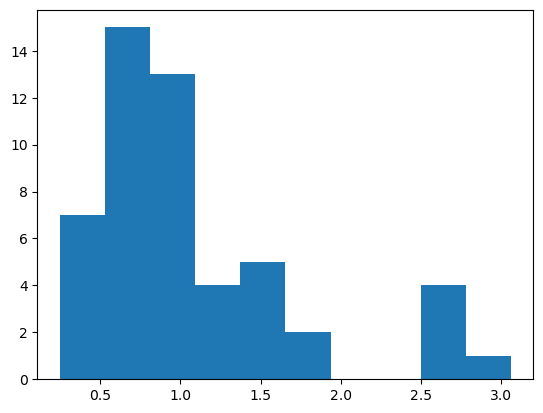

In [11]:
plt.hist(averages[averages.RepeatRate > 0.15].RepeatRate)

In [12]:
counts[counts.TotalReads == 0]

,Marker,Sample,TotalReads,TypedReads,RepetitiveReads,RepFlagged,Length,Ae,RepeatRate,Locus
744,mh05CP-010,SRM8398-1,0,0,0,True,50,1.172,0.0,mh05CP-010
745,mh05CP-010,SRM8398-2,0,0,0,True,50,1.172,0.0,mh05CP-010
746,mh05CP-010,SRM8398-3,0,0,0,True,50,1.172,0.0,mh05CP-010
747,mh05CP-010,SRM8398-4,0,0,0,True,50,1.172,0.0,mh05CP-010


In [13]:
averages.shape

(658, 5)

In [14]:
len(counts.Marker.unique())

658

In [15]:
counts["RepetitiveByRate"] = counts.RepeatRate.apply(lambda r: r > 0.15)

In [16]:
counts.groupby(["RepFlagged", "RepetitiveByRate"]).size()

RepFlagged  RepetitiveByRate
False       False               1472
            True                  52
True        False                952
            True                 156
dtype: int64

In [17]:
loci_rep_by_rate = set(counts[counts.RepetitiveByRate].Locus)
loci_rep_by_flag = set(counts[counts.RepFlagged].Locus)
averages["RepetitiveByRate"] = averages.Locus.apply(lambda x: x in loci_rep_by_rate)
averages["RepFlagged"] = averages.Locus.apply(lambda x: x in loci_rep_by_flag)
averages.drop_duplicates("Locus", keep="first").groupby(["RepFlagged", "RepetitiveByRate"]).size()

RepFlagged  RepetitiveByRate
False       False               235
            True                  4
True        False               155
            True                 21
dtype: int64

In [18]:
print(len(averages[averages.RepFlagged]))

290


In [27]:
print(*averages[~averages.RepFlagged & averages.RepetitiveByRate].Locus.unique())

mh03LV-06 mh19USC-19qB mh04KK-028 mh05USC-5qD


In [34]:
print(len(averages[averages.RepFlagged & ~averages.RepetitiveByRate].Locus.unique()))
print(*averages[averages.RepFlagged & ~averages.RepetitiveByRate].Locus.unique())

155
mh12CP-008 mh14CP-003 mh06LV-09 mh01USC-1qC mh10KK-163 mh07PK-38311 mh13CP-010 mh03CP-005 mh21KK-320 mh14PK-72639 mh15CP-004 mh10KK-083 mh21USC-21qB mh04USC-4pB mh18PK-87558 mh06PK-25713 mh09KK-034 mh06KK-104 mh11USC-11qB mh03KK-018 mh06USC-6qC mh21KK-315 mh18USC-18qB mh11CP-004 mh11KK-036 mh16KK-049 mh21KK-313 mh10KK-162 mh02USC-2qA mh04KK-030 mh15USC-15qC mh09USC-9qA mh17KK-013 mh08USC-8qC mh15USC-15qB mh11USC-11pA mh03KK-150 mh01CP-016 mh15CP-001 mh02KK-136 mh03KK-017 mh21KK-316 mh14USC-14qD mh05KK-170 mh02KK-014 mh14KK-227 mh13KK-222 mh05KK-120 mh16PK-83362 mh01USC-1pC mh07KK-009 mh11KK-183 mh20KK-306 mh03KK-047 mh20KK-058 mh01USC-1qB mh11KK-187 mh20KK-307 mh18KK-293 mh22PK-104638 mh17KK-110 mh05USC-5pA mh01NH-02 mh20USC-20pB mh09USC-9pA mh11CP-003 mh11KK-103 mh14KK-101 mh11KK-190 mh02KK-004 mh16USC-16pA mh03KK-016 mh07KK-030 mh12KK-202 mh01KK-213 mh19USC-19pA mh18USC-18pA mh10USC-10qC mh05USC-5pB mh18USC-18qC mh06KK-090 mh19KK-301 mh15PK-75170 mh17KK-012 mh08CP-009 mh15USC-15q

In [33]:
import random
s = random.sample(sorted(averages[averages.RepFlagged & ~averages.RepetitiveByRate].Locus.unique()), 4)
print(*s)

mh21KK-316 mh01KK-210 mh11KK-187 mh20USC-20qA


In [35]:
len(averages.Locus.unique())

415

In [36]:
235 + 4 + 155 + 21

415

In [17]:
unflagged_rep = counts[~counts.RepFlagged & counts.RepetitiveByRate]
unflagged_rep

,Marker,Sample,TotalReads,TypedReads,RepetitiveReads,RepFlagged,Length,Ae,RepeatRate,Locus,RepetitiveByRate
548,mh03LV-06.v1,SRM8398-1,2265,423,1495,False,198,13.540,0.660044,mh03LV-06,True
549,mh03LV-06.v1,SRM8398-2,2554,507,1983,False,198,13.540,0.776429,mh03LV-06,True
550,mh03LV-06.v1,SRM8398-3,1676,413,1152,False,198,13.540,0.687351,mh03LV-06,True
551,mh03LV-06.v1,SRM8398-4,2652,212,1969,False,198,13.540,0.742459,mh03LV-06,True
552,mh03LV-06.v2,SRM8398-1,2247,219,1495,False,194,4.806,0.665332,mh03LV-06,True
553,mh03LV-06.v2,SRM8398-2,2474,293,1983,False,194,4.806,0.801536,mh03LV-06,True
554,mh03LV-06.v2,SRM8398-3,1636,226,1152,False,194,4.806,0.704156,mh03LV-06,True
555,mh03LV-06.v2,SRM8398-4,2627,102,1969,False,194,4.806,0.749524,mh03LV-06,True
556,mh03LV-06.v3,SRM8398-1,2132,1114,1495,False,54,4.031,0.701220,mh03LV-06,True
557,mh03LV-06.v3,SRM8398-2,2374,1221,1983,False,54,4.031,0.835299,mh03LV-06,True


In [18]:
averages[averages.Marker.isin(unflagged_rep.Marker)]

,Marker,RepeatRate,Length,Ae,Locus
12,mh12KK-201.v4,1.264180,50,3.209,mh12KK-201
13,mh12KK-201.v1,1.217837,177,15.170,mh12KK-201
14,mh12KK-201.v2,1.217837,177,15.217,mh12KK-201
29,mh03LV-06.v3,0.758005,54,4.031,mh03LV-06
31,mh03LV-06.v2,0.730137,194,4.806,mh03LV-06
33,mh03LV-06.v1,0.716571,198,13.540,mh03LV-06
34,mh03LV-06.v5,0.701047,309,26.239,mh03LV-06
35,mh03LV-06.v4,0.699070,350,29.268,mh03LV-06
41,mh19USC-19qB.v1,0.561659,27,4.912,mh19USC-19qB
42,mh19USC-19qB.v3,0.558799,83,6.008,mh19USC-19qB


In [19]:
print(*averages[averages.Marker.isin(unflagged_rep.Marker)].Locus.unique())

mh12KK-201 mh03LV-06 mh19USC-19qB mh04KK-028 mh05USC-5qD


In [20]:
flagged_unrep = counts[counts.RepFlagged & ~counts.RepetitiveByRate]
flagged_unrep

,Marker,Sample,TotalReads,TypedReads,RepetitiveReads,RepFlagged,Length,Ae,RepeatRate,Locus,RepetitiveByRate
16,mh01CP-016,SRM8398-1,2973,2671,5,True,45,3.241,0.001682,mh01CP-016,False
17,mh01CP-016,SRM8398-2,3186,2825,7,True,45,3.241,0.002197,mh01CP-016,False
18,mh01CP-016,SRM8398-3,2173,1960,12,True,45,3.241,0.005522,mh01CP-016,False
19,mh01CP-016,SRM8398-4,3598,3084,1,True,45,3.241,0.000278,mh01CP-016,False
52,mh01KK-106,SRM8398-1,3198,783,1,True,171,3.294,0.000313,mh01KK-106,False
...,...,...,...,...,...,...,...,...,...,...,...
2627,mh22USC-22qB.v2,SRM8398-4,6079,105,3,True,261,8.161,0.000494,mh22USC-22qB,False
2628,mh22USC-22qB.v3,SRM8398-1,4927,410,1,True,251,8.337,0.000203,mh22USC-22qB,False
2629,mh22USC-22qB.v3,SRM8398-2,5886,582,2,True,251,8.337,0.000340,mh22USC-22qB,False
2630,mh22USC-22qB.v3,SRM8398-3,4167,399,1,True,251,8.337,0.000240,mh22USC-22qB,False


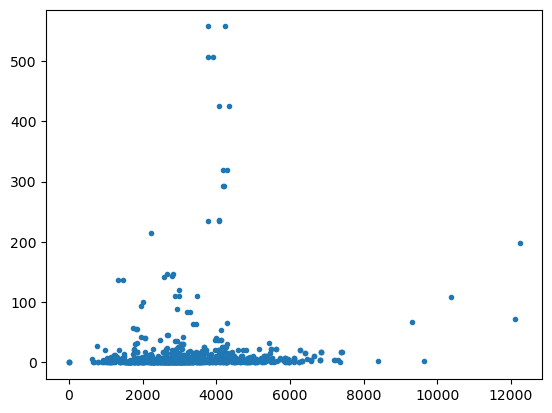

In [21]:
plt.scatter(flagged_unrep.TotalReads, flagged_unrep.RepetitiveReads, marker=".")

In [22]:
averages[averages.Marker.isin(flagged_unrep.Marker)]

,Marker,RepeatRate,Length,Ae,Locus
51,mh13KK-221.v2,0.128269,338,6.855,mh13KK-221
52,mh13KK-221.v1,0.115471,253,10.057,mh13KK-221
53,mh10LV-03.v2,0.112373,317,14.757,mh10LV-03
54,mh10LV-03.v1,0.109046,325,50.442,mh10LV-03
56,mh12CP-008,0.075891,34,1.000,mh12CP-008
...,...,...,...,...,...
643,mh12KK-209,0.000000,191,5.687,mh12KK-209
652,mh05CP-010,0.000000,50,1.172,mh05CP-010
653,mh04USC-4qC,0.000000,51,3.360,mh04USC-4qC
655,mh03USC-3qC.v3,0.000000,114,6.634,mh03USC-3qC
